# Preprocessing Concepts

### Below is a sample where we just print the center, left, right camera views, all data pre-processing will be made to work here before we train the network

In [2]:
import csv, cv2
import matplotlib.pyplot as plt
import numpy as np
from sklearn.utils import shuffle
import time, random
from math import isclose

STEER_CORRECTION = .25

start = time.time()

data = []
with open('./data/driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        data.append(line)

data = shuffle(data)

def readDataIn(data):
    images = []
    steering_angles = []
    
    for i in range(1,len(data)):
        if i > 100:
            break
        data_point = data[i]

        name = './data/IMG/'+ data_point[0].split('/')[-1]
        left = './data/IMG/'+ data_point[1].split('/')[-1]
        righ = './data/IMG/'+ data_point[2].split('/')[-1]
        
        #print(len(images), name)
        if name == "./data/IMG/center":
            continue
            
        center_image = cv2.cvtColor(cv2.imread(name), cv2.COLOR_BGR2RGB)
        left_image  = cv2.cvtColor(cv2.imread(left), cv2.COLOR_BGR2RGB)
        right_image = cv2.cvtColor(cv2.imread(righ), cv2.COLOR_BGR2RGB)

        #steering angles
        center_angle = float(data_point[3])
        left_angle = float(data_point[3]) + STEER_CORRECTION
        righ_angle = float(data_point[3]) - STEER_CORRECTION
        
        coinFlip = random.random()
        if isclose(center_angle, 0.0):
            if coinFlip > .7:
                images.extend( (center_image,left_image, right_image ) )
                steering_angles.extend( (center_angle, left_angle, righ_angle) )
        else:
            images.extend( (center_image,left_image, right_image ) )
            steering_angles.extend( (center_angle, left_angle, righ_angle) )
        #print(len(data))        
    return [images, steering_angles]
    
images, steering_angles = readDataIn(data)

finish = time.time()
print("It took: {} to upload, shuffle, put images to arrays".format(finish-start))

plt.figure(figsize=(20, 25))
for i in range(3):
    plt.subplot(1, 3, i + 1)    
    title = "A picture: {0}\nSteering angle: {1:.3f}".format(i, steering_angles[i])
    plt.title(title, wrap=True)
    plt.imshow(images[i])

It took: 4.562234878540039 to upload, shuffle, put images to arrays


In [3]:
print( len(images) )
print(len(steering_angles) )

201
201


## Flipped images

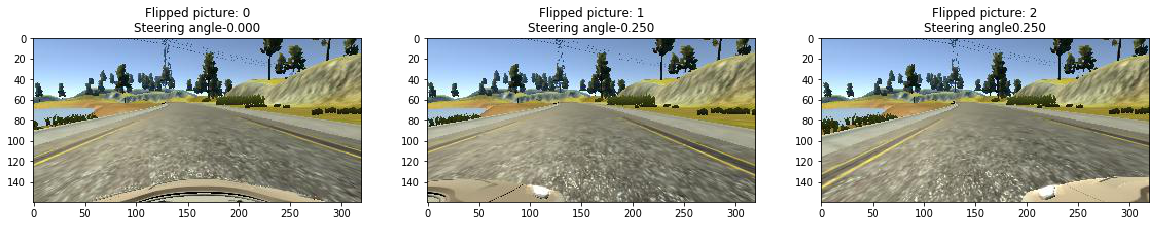

In [4]:
flipped_images = []
new_angles = []

for i in range(3):
    data_point = data[i]
    flipped = np.copy(np.fliplr(images[i]))   
    flipped_images.append(flipped)
    new_angles.append(-1*steering_angles[i])
    
plt.figure(figsize=(20, 25))
for i in range(3):
    plt.subplot(1, 3, i + 1)    
    title = "Flipped picture: {0}\nSteering angle{1:.3f}".format(i, new_angles[i])
    plt.title(title, wrap=True)
    plt.imshow(flipped_images[i])

## Change brightness

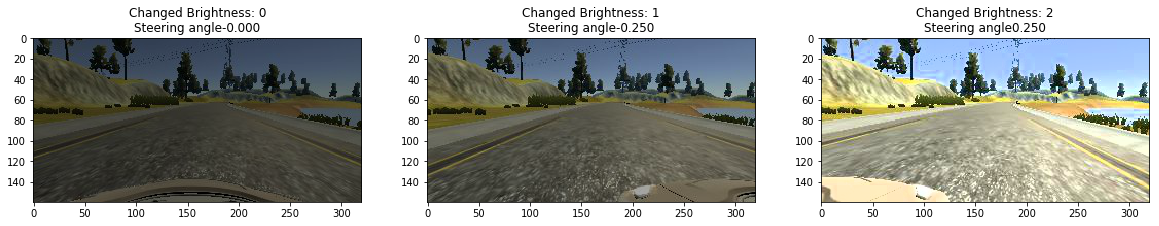

In [5]:
def change_brightness(image):
    img = np.copy(image)
    image1 = cv2.cvtColor(img,cv2.COLOR_RGB2HSV)
    image1 = np.array(image1,dtype=np.float64)
    # uniform means all outcomes equally likely, 
    # defaults to [0,1)
    random_bright = .4 + np.random.uniform()
    #print(random_bright)
    image1[:,:,2] = image1[:,:,2]*random_bright
    # Data conversion and array slicing schemes -> Reference: the amazing Vivek Yadav
    # https://chatbotslife.com/using-augmentation-to-mimic-human-driving-496b569760a9
    #(np slicing) --> Put any pixel that was made greater than 255 back to 255
    image1[:,:,2][image1[:,:,2]>255]  = 255
    image1 = np.array(image1, dtype = np.uint8)
    image1 = cv2.cvtColor(image1,cv2.COLOR_HSV2RGB)
    return image1

brightness_changed = []
# use angles

for i in range(3):    
    bright_diff = change_brightness(images[i])   
    brightness_changed.append(bright_diff)
    
plt.figure(figsize=(20, 25))
for i in range(3):
    plt.subplot(1, 3, i + 1)    
    title = "Changed Brightness: {0}\nSteering angle{1:.3f}".format(i, new_angles[i])
    plt.title(title, wrap=True)
    plt.imshow(brightness_changed[i])


## Crop
(found that if we take 50px off the top and 80 off the bottom the image is  totally road)

(160, 320, 3) 80
(70, 295, 3)


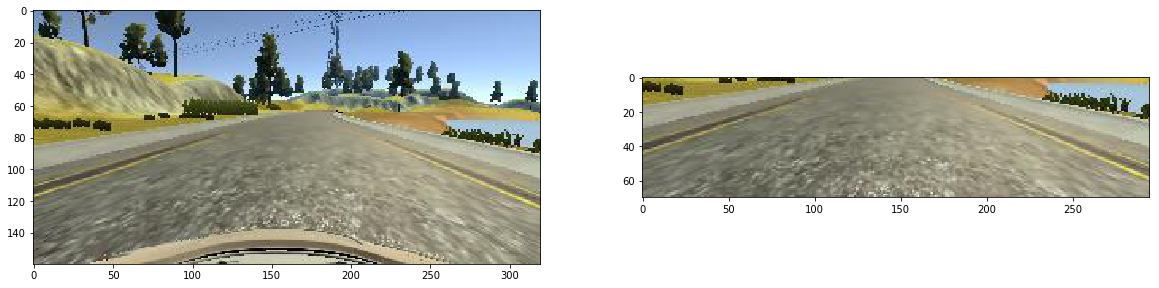

In [7]:
import cv2

def cropImage(img):     
    
    # top to cut off, bottom to cut off
    x,w = 25,img.shape[1]-25
    
    #left to cut off, right to cut off
    y,h = 65, (img.shape[0] - 90)
    crop_img = np.copy(img[y:y+h, x:x+w])
    return crop_img

img = images[0]
print(img.shape, img.shape[0] - 80)

crop_img = cropImage(img)

print(crop_img.shape)

def printTwoImages(img, changed_img):
    plt.figure(figsize=(20, 25))
    
    for i,v in enumerate([img,changed_img]): 
        plt.subplot(1, 2, i+1) 
        plt.imshow(v)
        '''
        plt.subplot(1, 2, 2) 
        plt.imshow(changed_img)
        '''
printTwoImages(img, crop_img)

## Normalize
won't print because all RGB values would be -1,0 or 1 and we'd need a ceil function, etc.

In [8]:
def normalize(img):
    # given in a tutorial or something
    return img/255 - .5
an_image = images[0]
an_image = normalize(an_image)

print(images[0])
print(an_image)

[[[120 150 200]
  [105 133 183]
  [110 136 187]
  ...
  [139 175 227]
  [139 175 227]
  [139 175 227]]

 [[110 141 188]
  [116 144 194]
  [132 158 207]
  ...
  [139 175 227]
  [139 175 227]
  [139 175 227]]

 [[110 143 188]
  [134 165 212]
  [109 137 185]
  ...
  [140 176 228]
  [140 176 228]
  [140 176 228]]

 ...

 [[111 109  97]
  [119 117 105]
  [130 128 116]
  ...
  [141 139 118]
  [144 142 121]
  [146 144 123]]

 [[129 127 115]
  [130 128 116]
  [125 123 111]
  ...
  [144 142 121]
  [148 146 125]
  [148 146 125]]

 [[137 135 123]
  [132 130 118]
  [135 133 121]
  ...
  [126 124 103]
  [137 135 114]
  [148 146 125]]]
[[[-0.02941176  0.08823529  0.28431373]
  [-0.08823529  0.02156863  0.21764706]
  [-0.06862745  0.03333333  0.23333333]
  ...
  [ 0.04509804  0.18627451  0.39019608]
  [ 0.04509804  0.18627451  0.39019608]
  [ 0.04509804  0.18627451  0.39019608]]

 [[-0.06862745  0.05294118  0.2372549 ]
  [-0.04509804  0.06470588  0.26078431]
  [ 0.01764706  0.11960784  0.31176471]
  

## Resize
to 200 x 166 per the NVIDIA model

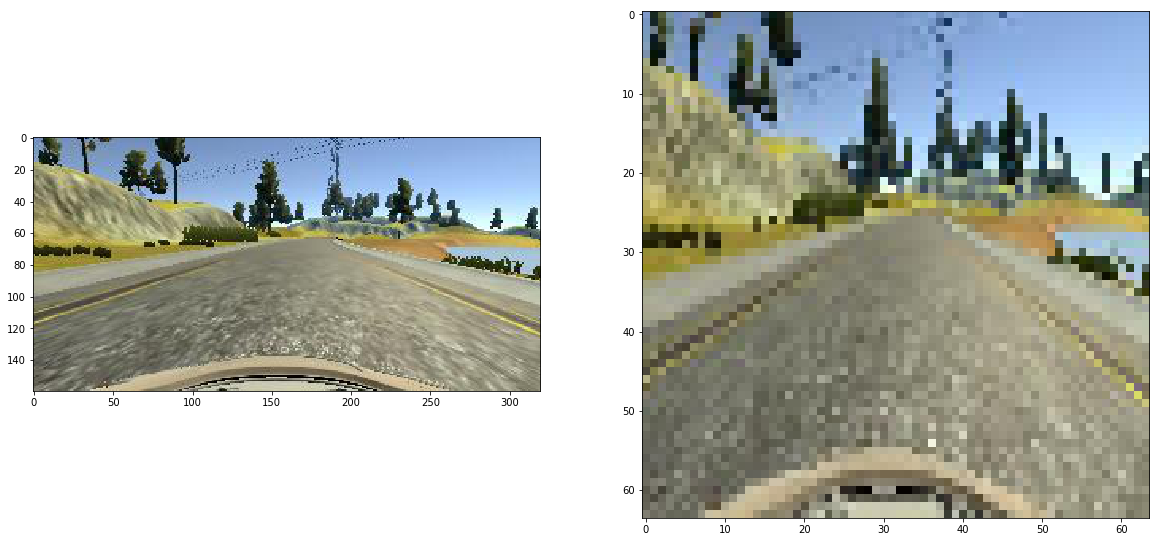

In [9]:
def resize(image):
    return np.copy(cv2.resize(image, (64,64) ) )

printTwoImages(img, resize(img))

## Flatten Steering Angle Distribution
(we want to get a before and after)

<class 'list'>


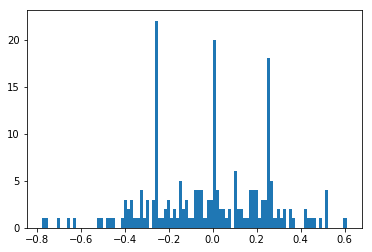

In [10]:
x = np.arange(-1.5,1.5,.05)
plt.hist(steering_angles,bins=100)

print(type(steering_angles))

In [11]:
#image_data = []
#steering_angle_data = []
from collections import Counter

angles = Counter(steering_angles)
print([i for i in list(angles.items()) if i[1] > 1000 ])

[]


In [12]:
data_shuffled = shuffle(data)
